In [74]:
import requests
from bs4 import BeautifulSoup
import re
from lxml import etree
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

IMDB_MOVIE_FILENAME = "imdb_top_250.json"
DOUBAN_MOVIE_FILENAME = "douban_top_250.json"
FAVORIATE_MOVIE_FILENAME = "favoriate_movies.json"

In [120]:
class imdb_movie:
    def __init__(self ,movie_id = None, url = None, name = None, rating = None, duration = None, short_description = None, year = None, genre = None, directors = None, actors = None, ranking = None, review_num = None, top_review_content = None):
        self.url = url
        self.name = name
        self.rating = rating
        self.duration = duration
        self.short_description = short_description
        self.year = year
        self.genre = genre
        self.directors = directors
        self.actors = actors
        self.ranking = ranking
        self.movie_id = movie_id
        self.review_num = review_num
        self.top_review_content = top_review_content

    def movie_imdb_info(self):
        data = {
            "url": self.url,
            "movie_id": self.movie_id
        }
        return data

    def movie_basic_info(self):
        data = {
            "genre": self.genre,
            "year": self.year,
            "duration": self.duration,
            "actors": self.actors,
            "directors": self.directors}
        return data

    def quantitative_info(self):
        data = {
            "ranking": self.ranking,
            "rating": self.rating,
            "review_num": self.review_num,
            "top_review_content": self.top_review_content}
        return data

    def movie_info(self):
        data = { "name": self.name, 
                "imdb_info": self.movie_imdb_info(),
                "basic_info": self.movie_basic_info(),
                "quantitative_info": self.quantitative_info()}
        return data


In [ ]:
class douban_movie:
    def __init__(self, url = None, name = None, movie_id = None, rating = None, duration = None, short_description = None, year = None, genre = None, directors = None, actors = None, ranking = None, rating_num = None):
        self.name = name
        self.rating = rating
        self.duration = duration
        self.short_description = short_description
        self.year = year
        self.genre = genre
        self.directors = directors
        self.actors = actors
        self.ranking = ranking
        self.rating_num = rating_num
        self.movie_id = movie_id
        self.url = url
        
    def movie_imdb_info(self):
        data = {
            "url": self.url,
            "movie_id": self.movie_id
        }
        return data
    
    def movie_basic_info(self):
        data = {
            "genre": self.genre,
            "year": self.year,
            "duration": self.duration,
            "actors": self.actors,
            "directors": self.directors}
        return data
    
    def quantitative_info(self):
        data = {
            "ranking": self.ranking,
            "rating": self.rating,
            "rating_num": self.rating_num,
            "short_description": self.short_description}
        return data
    
    def movie_info(self):
        data = { "name": self.name, 
                "imdb_info": self.movie_imdb_info(),
                "basic_info": self.movie_basic_info(),
                "quantitative_info": self.quantitative_info()}
        return data


In [121]:
def build_imdb_list_from_top_250():

    imdb_url = 'http://www.imdb.com/chart/top'
    imdb_req = requests.get(imdb_url)
    imdb_soup = BeautifulSoup(imdb_req.text, 'lxml')
    imdb_movies = imdb_soup.select('td.titleColumn')

    imdb_url = ['https://www.imdb.com' + a.attrs.get('href') for a in imdb_soup.select('td.titleColumn a')]
    imdb_actors = [a.attrs.get('title') for a in imdb_soup.select('td.titleColumn a')]
    imdb_ratings = [b.attrs.get('data-value') for b in imdb_soup.select('td.posterColumn span[name=ir]')]

    imdb_list_in = []

    for index in range(0, len(imdb_movies)):
        movie_string = imdb_movies[index].get_text()
        movie = (' '.join(movie_string.split()).replace('.', ''))
        movie_crew_split = imdb_actors[index].split(',')
        movie_dir = movie_crew_split[0].strip('(.dir)')
        movie_actor = re.sub('^[^,]*(?=,),', '', imdb_actors[index])
        movie_title = movie[len(str(index))+1:-7]
        year = re.search('\((.*?)\)', movie_string).group(1)
        ranking = movie[:len(str(index))-(len(movie))]
        movie_ids = imdb_url[index].split('/')[-2]
        imdb_data = imdb_movie(url = imdb_url[index], movie_id = movie_ids, name  = movie_title, rating = imdb_ratings[index], year = year, actors = movie_actor, ranking = ranking, directors=movie_dir)
        imdb_list_in.append(imdb_data)
    return imdb_list_in

In [122]:
def build_imdb_list_from_sub_html():
    imdb_list = build_imdb_list_from_top_250()
    for index in range(0, len(imdb_list)):
        sub_url = imdb_list[index].url
        sub_req = requests.get(sub_url)
        sub_soup = BeautifulSoup(sub_req.text, 'lxml')
        sub_time = sub_soup.find('div', class_='sc-94726ce4-3 eSKKHi').find_all("li")[-1].get_text()
        sub_description = sub_soup.select('span.sc-16ede01-1.kgphFu')[0].get_text()
        sub_rated_num = sub_soup.find('div', class_= 'sc-66a20916-0').select('span')[0].get_text()
        sub_top_review_content = sub_soup.find_all('div', class_='ipc-html-content-inner-div')[-1].get_text()
        try:
            init_genre = sub_soup.find_all('div', class_='sc-16ede01-4')[-1].get_text()
        except : IndexError
        pattern = "[A-Z]"
        sub_genre = re.sub(pattern, lambda x: " " + x.group(0), init_genre)
        imdb_list[index].genre = sub_genre
        imdb_list[index].duration = sub_time
        imdb_list[index].short_description = sub_description
        imdb_list[index].review_num = sub_rated_num
        imdb_list[index].top_review_content = sub_top_review_content

    return imdb_list

imdb_list = build_imdb_list_from_sub_html() # This may run slow, please be patient

In [135]:
def save_imdb_cache(imdb_list: imdb_movie):
    f = open(IMDB_MOVIE_FILENAME, 'w').close()
    for index in range(0, len(imdb_list)):
        imdb_list[index].movie_info()
        with open(IMDB_MOVIE_FILENAME, 'a') as f:
            f.write(json.dumps(imdb_list[index].movie_info(), indent=4))
            if index != len(imdb_list)-1:
                f.write(',')
    with open(IMDB_MOVIE_FILENAME, 'a') as f:
        f.write(']')
    with open(IMDB_MOVIE_FILENAME, 'r+') as file:
        content = file.read()
        file.seek(0)
        file.write('[' + content)
    f.close()

save_imdb_cache(imdb_list)

In [ ]:
def get_douban_url():
    urls = []
    for i in range(1, 4):
        url = 'https://www.imdb.com/list/ls066077036/?sort=list_order,asc&st_dt=&mode=detail&page={}'.format(i)
        urls.append(url)
    return urls

def build_douban_top_250():
    douban_url_list = get_douban_url()
    douban_list_in = []
    for i in range(0, len(douban_url_list)):
        douban_req = requests.get(douban_url_list[i])
        douban_soup = BeautifulSoup(douban_req.text, 'lxml')
        if i != 2:
            for j in range(0, 100):
                douban_movies = douban_soup.find_all('div', class_='lister-list')[0].find_all('div', class_='lister-item-content')[j]
                douban_url = douban_movies.find('a')['href']
                douban_movie_id = douban_url.split('/')[-2]
                douban_in_imdb_url = 'https://www.imdb.com' + douban_url
                douban_name = douban_movies.find('h3').find('a').text
                douban_rating = douban_movies.find('span', class_='ipl-rating-star__rating').text
                douban_ranking = douban_movies.find('h3').find('span', class_ = "lister-item-index unbold text-primary").text.replace('.', '')
                try:
                    douban_duration = douban_movies.find('span', class_='runtime').text.replace(' min', '')
                    douban_duration = str(int(douban_duration)//60) + "h" + " " + str(int(douban_duration)%60) + "m"
                except: AttributeError
                douban_short_description = douban_movies.find('p', class_='').text.replace('\n', '')
                douban_genre = douban_movies.find('span', class_='genre').text.replace('\n', '').replace(' ', '').replace(',', '/')
                movie_year = douban_movies.find('span', class_='lister-item-year text-muted unbold').text.replace('(', '').replace(')', '')
                douban_directors = douban_movies.find_all('p', class_='text-muted')[1].find('a').text
                douban_actors = douban_movies.find_all('p', class_='text-muted')[1].find_all('a')[1:]
                douban_actors = [actor.text for actor in douban_actors]
                douban_actors = ', '.join(douban_actors)
                douban_review_num = douban_movies.find_all('p', class_ = 'text-muted')[-1].find_all('span')[1].text
                douban_data = douban_movie(name = douban_name, rating = douban_rating, ranking = douban_ranking, duration = douban_duration, 
                                           short_description = douban_short_description, genre = douban_genre, directors = douban_directors, actors = douban_actors, rating_num = douban_review_num, 
                                           movie_id = douban_movie_id, url = douban_in_imdb_url, year = movie_year)
                print(j)
                douban_list_in.append(douban_data)
        if i == 2:
            for j in range(0, 49):
                douban_movies = douban_soup.find_all('div', class_='lister-list')[0].find_all('div', class_='lister-item-content')[j]
                douban_url = douban_movies.find('a')['href']
                douban_movie_id = douban_url.split('/')[-2]
                douban_in_imdb_url = 'https://www.imdb.com' + douban_url
                douban_name = douban_movies.find('h3').find('a').text
                douban_rating = douban_movies.find('span', class_='ipl-rating-star__rating').text
                douban_ranking = douban_movies.find('h3').find('span', class_ = "lister-item-index unbold text-primary").text.replace('.', '')
                try:
                    douban_duration = douban_movies.find('span', class_='runtime').text.replace(' min', '')
                    douban_duration = str(int(douban_duration)//60) + "h" + " " + str(int(douban_duration)%60) + "m"
                except: AttributeError
                douban_short_description = douban_movies.find('p', class_='').text.replace('\n', '')
                douban_genre = douban_movies.find('span', class_='genre').text.replace('\n', '').replace(' ', '').replace(',', '/')
                douban_directors = douban_movies.find_all('p', class_='text-muted')[1].find('a').text
                douban_actors = douban_movies.find_all('p', class_='text-muted')[1].find_all('a')[1:]
                douban_actors = [actor.text for actor in douban_actors]
                douban_actors = ', '.join(douban_actors)
                douban_review_num = douban_movies.find_all('p', class_ = 'text-muted')[-1].find_all('span')[1].text
                douban_data = douban_movie(name = douban_name, rating = douban_rating, ranking = douban_ranking, duration = douban_duration, 
                                           short_description = douban_short_description, genre = douban_genre, directors = douban_directors, actors = douban_actors, rating_num = douban_review_num, 
                                           movie_id = douban_movie_id, url = douban_in_imdb_url, year = movie_year)
                douban_list_in.append(douban_data)
                print(j)
    return douban_list_in

douban_list = build_douban_top_250()


In [ ]:
def save_douban_cache(douban_list: douban_movie):
    f = open(DOUBAN_MOVIE_FILENAME, 'w').close()
    for index in range(0, len(douban_list)):
        douban_list[index].movie_info()
        with open(DOUBAN_MOVIE_FILENAME, 'a') as f:
            f.write(json.dumps(douban_list[index].movie_info(), indent=4))
            if index != len(douban_list)-1:
                f.write(',')
    with open(DOUBAN_MOVIE_FILENAME, 'a') as f:
        f.write(']')
    with open(DOUBAN_MOVIE_FILENAME, 'r+') as file:
        content = file.read()
        file.seek(0)
        file.write('[' + content)
    f.close()

save_douban_cache(douban_list)

In [136]:
imdb_json = json.load(open(IMDB_MOVIE_FILENAME))
douban_json = json.load(open(DOUBAN_MOVIE_FILENAME))

def create_imdb_dict_year(json):
    imdb_tree = {}
    for index in range(0, len(json)):
        imdb_tree[json[index]['basic_info']['year']] = json[index]
    return imdb_tree



In [3]:
def check_cache_file():
    if os.path.exists(IMDB_MOVIE_FILENAME) and os.path.exists(DOUBAN_MOVIE_FILENAME):
        print("Cache file existance: Yes")
    else:
        print("Cache file existance: No")
        print("Please wait for the cache file to be created.")
        imdb_list = build_imdb_list_from_sub_html()
        save_imdb_cache(imdb_list)
        douban_list = build_douban_top_250()
        save_douban_cache(douban_list)
        print("Cache file created.")

In [4]:
def movie_name_search(movie_name, movie_json):
    name_list = []
    for index in range(0, len(movie_json)):
        name_list.append(movie_json[index]['name'].lower())
    match_list = [k for k in name_list if movie_name.lower() in k]
    for i in match_list:
        print("Found: " + i.title())
    ori_name_list = [k for k in movie_json if k['name'].lower() in match_list]
    return ori_name_list

def save_movie_to_favorite(movie_json: dict):
    with open(FAVORIATE_MOVIE_FILENAME, 'a') as f:
        f.write(json.dumps(movie_json, indent=4))
    print("Movie saved to favorite.")


def movie_name_search_menu(json_one, json_two):
    movie_name = input("Please enter the movie name: ").lower()
    first_result = movie_name_search(movie_name, json_one)
    if first_result == [] or first_result == None:
        choice = input("No result found. Do you want to search again in another source? [Y/N]").lower()
        if choice == 'y':
            second_result = movie_name_search(movie_name, json_two)
            if second_result == [] or second_result == None:
                print("No result found.")
                input("Press Enter to continue...")
            else :
                print(json.dumps(second_result, indent=4))
                save_choice = input("Do you want to save those movie to your favorite list? [Y/N]")
                if save_choice == 'y':
                    save_movie_to_favorite(second_result)
                    input("Press Enter to continue...")
    elif first_result != None:
            print(json.dumps(first_result, indent=4))
            save_choice = input("Do you want to save this movie to your favorite list? [Y/N]")
            if save_choice == 'y':
                    save_movie_to_favorite(first_result)
            input("Press Enter to continue...")


In [17]:
def movie_genre_search(genre, movie_json):
    genre_list = []
    for index in range(0, len(movie_json)):
        if genre in movie_json[index]['basic_info']['genre'].lower():
            genre_list.append(movie_json[index])
    for i in genre_list:
        print("Name: {}".format(i['name']))
    return genre_list

def movie_genre_search_menu(json_one, json_two):
    genre = input("Please enter the movie genre: ").lower()
    first_result = movie_genre_search(genre, json_one)
    if first_result == [] or first_result == None:
        choice = input("No result found. Do you want to search again in another source? [Y/N]").lower()
        if choice == 'y':
            second_result = movie_genre_search(genre, json_two)
            if second_result == [] or second_result == None:
                print("No result found.")
                input("Press Enter to continue...")
            else :
                # print(json.dumps(second_result['name'], indent=4))
                save_choice = input("Do you want to save those movie to your favorite list? [Y/N]")
                if save_choice == 'y':
                    save_movie_to_favorite(second_result)
                    input("Press Enter to continue...")
    elif first_result != None:
            # print(json.dumps(first_result['name'], indent=4))
            save_choice = input("Do you want to save this movie to your favorite list? [Y/N]")
            if save_choice == 'y':
                    save_movie_to_favorite(first_result)
            input("Press Enter to continue...")


In [32]:
def movie_year_search(year, movie_json):
    year_list = []
    for index in range(0, len(movie_json)):
        if year in movie_json[index]['basic_info']['year'].lower():
            year_list.append(movie_json[index])
    for i in year_list:
        print("Name: {} ({})".format(i['name'], i['basic_info']['year']))
    return year_list

def movie_year_search_menu(json_one, json_two):
    year = input("Please enter the movie year: ").lower()
    first_result = movie_year_search(year, json_one)
    if first_result == [] or first_result == None:
        choice = input("No result found. Do you want to search again in another source? [Y/N]").lower()
        if choice == 'y':
            second_result = movie_year_search(year, json_two)
            if second_result == [] or second_result == None:
                print("No result found in another source, sorry.")
                input("Press Enter to continue...")
            else :
                # print(json.dumps(second_result['name'], indent=4))
                save_choice = input("Do you want to save those movie to your favorite list? [Y/N]")
                if save_choice == 'y':
                    save_movie_to_favorite(second_result)
                    input("Press Enter to continue...")
    elif first_result != None:
            # print(json.dumps(first_result['name'], indent=4))
            save_choice = input("Do you want to save this movie to your favorite list? [Y/N]")
            if save_choice == 'y':
                    save_movie_to_favorite(first_result)
            input("Press Enter to continue...")

In [45]:
def movie_ranking_search(lower, upper, movie_json):
    ranking_list = []
    for index in range(lower-1, upper):
        ranking_list.append(movie_json[index])
    for i in ranking_list:
        print("Name: {} ({})".format(i['name'], i['quantitative_info']['ranking']))
    return ranking_list

def movie_ranking_search_menu(json_one, json_two):
    upper = int(input("Please enter the higher ranking index, for example, if you want to search from 1 to 5, enter 5: "))
    lower = int(input("Please enter the lower ranking index, for example, if you want to search from 1 to 5, enter 1: "))
    first_result = movie_ranking_search(lower, upper, json_one)
    if first_result == [] or first_result == None:
        choice = input("No result found. Do you want to search again in another source? [Y/N]").lower()
        if choice == 'y':
            second_result = movie_ranking_search(lower, upper, json_two)
            if second_result == [] or second_result == None:
                print("No result found in another source, sorry.")
                input("Press Enter to continue...")
            else :
                # print(json.dumps(second_result['name'], indent=4))
                save_choice = input("Do you want to save those movie to your favorite list? [Y/N]")
                if save_choice == 'y':
                    save_movie_to_favorite(second_result)
                    input("Press Enter to continue...")
    elif first_result != None:
            # print(json.dumps(first_result['name'], indent=4))
            save_choice = input("Do you want to save this movie to your favorite list? [Y/N]")
            if save_choice == 'y':
                    save_movie_to_favorite(first_result)
            input("Press Enter to continue...")

In [43]:
douban_json = json.load(open(DOUBAN_MOVIE_FILENAME))
imdb_json = json.load(open(IMDB_MOVIE_FILENAME))
movie_ranking_search_menu(douban_json, imdb_json)

Name: The Shawshank Redemption (1)
Name: Léon: The Professional (2)
Name: Farewell My Concubine (3)
Name: Forrest Gump (4)
Name: Life Is Beautiful (5)
Name: Spirited Away (6)
Movie saved to favorite.


In [116]:

# This function is used to calculate the mean rating of movies in a year and plot the result
def visualize_movie_rating_distribution_by_year(json_one):
	year_list = []
	for index in range(0, len(json_one)):
		year_list.append(json_one[index]['basic_info']['year'])
	year_list = list(set(year_list))
	year_list.sort()
	for year in year_list:
		year_rating_list = []
		for index in range(0, len(json_one)):
			if json_one[index]['basic_info']['year'] == year:
				year_rating_list.append(json_one[index]['quantitative_info']['rating'])
		year_rating_list = list(map(float, year_rating_list))
		mean_rating = round(sum(year_rating_list)/len(year_rating_list), 2)
		#print("Year: {}\tMean Rating: {}".format(year, mean_rating))
		plt.bar(year, mean_rating, color='blue')
	plt.xlabel('Year')
	plt.ylabel('Mean Rating')
	plt.title('Mean Rating of Movies in Different Years')
	plt.xticks(rotation=270)
	plt.show()
	
	input("Press Enter to continue...")

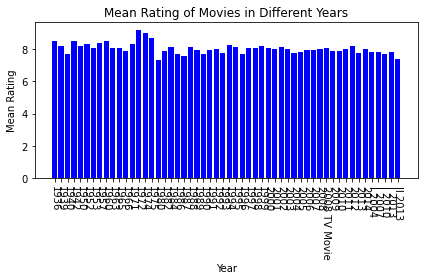

In [117]:
visualize_movie_rating_distribution_by_year(douban_json)

In [105]:
def search_menu(json_one, json_two):
    print("Please enter the Search Preference:")
    print("1. Search by Movie Name")
    print("2. Search by Movie Genre")
    print("3. Search by Movie Year")
    print("4. Search by Ranking in Source Top 250")
    print("5. Visualize Rating of top 250 movies by year")
    print("6. Back to source selection")
    while True:
        try:
            search_preference = int(input("Please enter the number of your preference: "))
            if search_preference < 1 or search_preference > 6:
                raise ValueError
            break
        except ValueError:
            print("Please enter a valid number.")
            continue
    if search_preference == 6:
        return
    if search_preference == 1:
        movie_name_search_menu(json_one, json_two)
    if search_preference == 2:
        movie_genre_search_menu(json_one, json_two)
    if search_preference == 3:
        movie_year_search_menu(json_one, json_two)
    if search_preference == 4:
        movie_ranking_search_menu(json_one, json_two)
    if search_preference == 5:
        visualize_movie_rating_distribution_by_year(json_one)
        # movie_name = input("Please enter the movie name: ").lower()
        # first_result = movie_name_search(movie_name, json_one)
        # if first_result == None:
        #     choice = input("No result found. Do you want to search again in another source? [Y/N]").lower()
        #     if choice == 'y':
        #         second_result = movie_name_search(movie_name, json_two)
        #         if second_result == None:
        #             print("No result found.")
        #             input("Press Enter to continue...")
        #         else :
        #             print(json.dumps(second_result, indent=4))
        #             input("Press Enter to continue...")
        # elif first_result != None:
        #     print(json.dumps(first_result, indent=4))
        #     input("Press Enter to continue...")



In [106]:
def main():
    print("Welcome to Movie Recommender!")
    print("The Movie Recommender is an application that recommends movies based on your preferences.")
    print("Check out the cache file existance.")
    check_cache_file()
    imdb_json = json.load(open(IMDB_MOVIE_FILENAME))
    douban_json = json.load(open(DOUBAN_MOVIE_FILENAME))
    
    
    while True:
        print("Please select source of recommendation:")
        print("1. IMDB")
        print("2. Douban")
        print("3. Exit")
        source = input("Please enter the number of the source: ")
        if source == '1':
            search_menu(imdb_json, douban_json)
        elif source == '2':
            search_menu(douban_json, imdb_json)
        elif source == '3':
            print("Thank you for using the Movie Recommender!")
            return
        else:
            print("Please enter a valid number.")


Welcome to Movie Recommender!
The Movie Recommender is an application that recommends movies based on your preferences.
Check out the cache file existance.
Cache file existance: Yes
Please select source of recommendation:
1. IMDB
2. Douban
3. Exit
Please enter a valid number.
Please select source of recommendation:
1. IMDB
2. Douban
3. Exit
Please enter the Search Preference:
1. Search by Movie Name
2. Search by Movie Genre
3. Search by Movie Year
4. Search by Ranking in Source Top 250
5. Visualize Rating of top 250 movies by year
6. Back to source selection
Please select source of recommendation:
1. IMDB
2. Douban
3. Exit
Thank you for using the Movie Recommender!


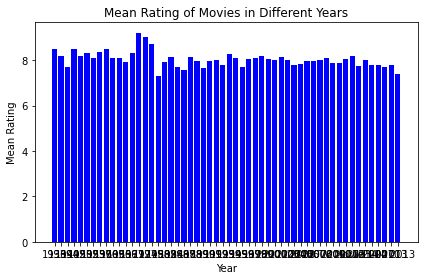

<Figure size 720x72 with 0 Axes>

In [108]:
main()

In [117]:
class douban_movie:
    def __init__(self, url = None, name = None, movie_id = None, rating = None, duration = None, short_description = None, year = None, genre = None, directors = None, actors = None, ranking = None, rating_num = None):
        self.name = name
        self.rating = rating
        self.duration = duration
        self.short_description = short_description
        self.year = year
        self.genre = genre
        self.directors = directors
        self.actors = actors
        self.ranking = ranking
        self.rating_num = rating_num
        self.movie_id = movie_id
        self.url = url
        
    def movie_imdb_info(self):
        data = {
            "url": self.url,
            "movie_id": self.movie_id
        }
        return data
    
    def movie_basic_info(self):
        data = {
            "genre": self.genre,
            "year": self.year,
            "duration": self.duration,
            "actors": self.actors,
            "directors": self.directors}
        return data
    
    def quantitative_info(self):
        data = {
            "ranking": self.ranking,
            "rating": self.rating,
            "rating_num": self.rating_num,
            "short_description": self.short_description}
        return data
    
    def movie_info(self):
        data = { "name": self.name, 
                "imdb_info": self.movie_imdb_info(),
                "basic_info": self.movie_basic_info(),
                "quantitative_info": self.quantitative_info()}
        return data


In [133]:
def get_douban_url():
    urls = []
    for i in range(1, 4):
        url = 'https://www.imdb.com/list/ls066077036/?sort=list_order,asc&st_dt=&mode=detail&page={}'.format(i)
        urls.append(url)
    return urls

def build_douban_top_250():
    douban_url_list = get_douban_url()
    douban_list_in = []
    for i in range(0, len(douban_url_list)):
        douban_req = requests.get(douban_url_list[i])
        douban_soup = BeautifulSoup(douban_req.text, 'lxml')
        if i != 2:
            for j in range(0, 100):
                douban_movies = douban_soup.find_all('div', class_='lister-list')[0].find_all('div', class_='lister-item-content')[j]
                douban_url = douban_movies.find('a')['href']
                douban_movie_id = douban_url.split('/')[-2]
                douban_in_imdb_url = 'https://www.imdb.com' + douban_url
                douban_name = douban_movies.find('h3').find('a').text
                douban_rating = douban_movies.find('span', class_='ipl-rating-star__rating').text
                douban_ranking = douban_movies.find('h3').find('span', class_ = "lister-item-index unbold text-primary").text.replace('.', '')
                try:
                    douban_duration = douban_movies.find('span', class_='runtime').text.replace(' min', '')
                    douban_duration = str(int(douban_duration)//60) + "h" + " " + str(int(douban_duration)%60) + "m"
                except: AttributeError
                douban_short_description = douban_movies.find('p', class_='').text.replace('\n', '')
                douban_genre = douban_movies.find('span', class_='genre').text.replace('\n', '').replace(' ', '').replace(',', '/')
                movie_year = douban_movies.find('span', class_='lister-item-year text-muted unbold').text.replace('(', '').replace(')', '')
                douban_directors = douban_movies.find_all('p', class_='text-muted')[1].find('a').text
                douban_actors = douban_movies.find_all('p', class_='text-muted')[1].find_all('a')[1:]
                douban_actors = [actor.text for actor in douban_actors]
                douban_actors = ', '.join(douban_actors)
                douban_review_num = douban_movies.find_all('p', class_ = 'text-muted')[-1].find_all('span')[1].text
                douban_data = douban_movie(name = douban_name, rating = douban_rating, ranking = douban_ranking, duration = douban_duration, 
                                           short_description = douban_short_description, genre = douban_genre, directors = douban_directors, actors = douban_actors, rating_num = douban_review_num, 
                                           movie_id = douban_movie_id, url = douban_in_imdb_url, year = movie_year)
                print(j)
                douban_list_in.append(douban_data)
        if i == 2:
            for j in range(0, 49):
                douban_movies = douban_soup.find_all('div', class_='lister-list')[0].find_all('div', class_='lister-item-content')[j]
                douban_url = douban_movies.find('a')['href']
                douban_movie_id = douban_url.split('/')[-2]
                douban_in_imdb_url = 'https://www.imdb.com' + douban_url
                douban_name = douban_movies.find('h3').find('a').text
                douban_rating = douban_movies.find('span', class_='ipl-rating-star__rating').text
                douban_ranking = douban_movies.find('h3').find('span', class_ = "lister-item-index unbold text-primary").text.replace('.', '')
                try:
                    douban_duration = douban_movies.find('span', class_='runtime').text.replace(' min', '')
                    douban_duration = str(int(douban_duration)//60) + "h" + " " + str(int(douban_duration)%60) + "m"
                except: AttributeError
                douban_short_description = douban_movies.find('p', class_='').text.replace('\n', '')
                douban_genre = douban_movies.find('span', class_='genre').text.replace('\n', '').replace(' ', '').replace(',', '/')
                douban_directors = douban_movies.find_all('p', class_='text-muted')[1].find('a').text
                douban_actors = douban_movies.find_all('p', class_='text-muted')[1].find_all('a')[1:]
                douban_actors = [actor.text for actor in douban_actors]
                douban_actors = ', '.join(douban_actors)
                douban_review_num = douban_movies.find_all('p', class_ = 'text-muted')[-1].find_all('span')[1].text
                douban_data = douban_movie(name = douban_name, rating = douban_rating, ranking = douban_ranking, duration = douban_duration, 
                                           short_description = douban_short_description, genre = douban_genre, directors = douban_directors, actors = douban_actors, rating_num = douban_review_num, 
                                           movie_id = douban_movie_id, url = douban_in_imdb_url, year = movie_year)
                douban_list_in.append(douban_data)
                print(j)
    return douban_list_in

douban_list = build_douban_top_250()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


In [134]:
def save_douban_cache(douban_list: douban_movie):
    f = open(DOUBAN_MOVIE_FILENAME, 'w').close()
    for index in range(0, len(douban_list)):
        douban_list[index].movie_info()
        with open(DOUBAN_MOVIE_FILENAME, 'a') as f:
            f.write(json.dumps(douban_list[index].movie_info(), indent=4))
            if index != len(douban_list)-1:
                f.write(',')
    with open(DOUBAN_MOVIE_FILENAME, 'a') as f:
        f.write(']')
    with open(DOUBAN_MOVIE_FILENAME, 'r+') as file:
        content = file.read()
        file.seek(0)
        file.write('[' + content)
    f.close()

save_douban_cache(douban_list)

In [ ]:
if __name__ == '__main__':
     main()